# Marketing Analytics Project 2

In [1]:
# read the csv data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

products = pd.read_csv('product_table.csv')
transactions = pd.read_csv('transaction_table.csv')

## Following same data cleaning as in Project 1

In [2]:
#To fix this, we will create our own transaction ID (Grouping by customer, store and date)
temp = transactions.groupby(['cust_id', 'tran_dt', 'store_id']).size().reset_index().rename(columns = {0:'trans_id'})
temp['trans_id'] = temp.index
print(temp.iloc[0:10, ])

# Next we perform a join to get this id column into the transactions df
transactions = transactions.set_index(['cust_id', 'tran_dt','store_id']).join(temp.set_index(['cust_id', 'tran_dt','store_id']))

   cust_id     tran_dt  store_id  trans_id
0    29568  2016-03-01       192         0
1    29568  2016-03-03       192         1
2    29568  2016-03-04       192         2
3    29568  2016-03-09       192         3
4    29568  2016-03-11       192         4
5    29568  2016-03-12       192         5
6    29568  2016-04-02       192         6
7    29568  2016-04-03       192         7
8    29568  2016-04-05       192         8
9    29568  2016-04-07       192         9


In [3]:
# Here, we drop the old ID column, and reorder the columns
transactions = transactions.reset_index()
transactions = transactions.drop('tran_id', axis = 1)
cols = list(transactions.columns.values)
print(cols)
newcols = ['cust_id', 'trans_id', 'tran_dt', 'store_id', 'prod_id', 'prod_unit', 
           'tran_prod_sale_amt', 'tran_prod_sale_qty', 
           'tran_prod_discount_amt', 'tran_prod_offer_cts', 'tran_prod_paid_amt', 'prod_unit_price']
transactions = transactions[newcols]

['cust_id', 'tran_dt', 'store_id', 'prod_id', 'prod_unit', 'tran_prod_sale_amt', 'tran_prod_sale_qty', 'tran_prod_discount_amt', 'tran_prod_offer_cts', 'tran_prod_paid_amt', 'prod_unit_price', 'trans_id']


In [4]:
# We are going to keep the $0.00 transactions but get rid of the negative instances
transactions = transactions[transactions['tran_prod_paid_amt']>=0]

In [5]:
#Let's merge both df's to create a complete one
complete_df = pd.merge(transactions,products,left_on = 'prod_id', right_on = 'prod_id', how = 'left') #.drop('prod_id', axis = 1)
print(len(transactions), ', ', len(complete_df))

complete_df.head(5)

29617577 ,  29617577


,cust_id,trans_id,tran_dt,store_id,prod_id,prod_unit,tran_prod_sale_amt,tran_prod_sale_qty,tran_prod_discount_amt,tran_prod_offer_cts,tran_prod_paid_amt,prod_unit_price,subcategory_id,sub_category_desc,category_id,category_desc,brand_desc,category_desc_eng
0,29568,0,2016-03-01,192,230909010,CT,3.87,3.0,-1.95,1,1.92,1.29,93994.0,IOGURTE TRAD AROMAS,95858.0,IOGURTES TRADICIONAIS,LONGA VIDA,YOGURT TRADITIONAL
1,29568,0,2016-03-01,192,266417009,CT,2.59,1.0,-1.30,1,1.29,2.59,93975.0,IOGURTE MAGRO LIQUID,95854.0,IOGURTE SAUDE,YOGGI,YOGURT HEALTH
2,29568,0,2016-03-01,192,486635012,CT,3.85,1.0,0.00,0,3.85,3.85,91790.0,IOG ANTI COLESTROL,95854.0,IOGURTE SAUDE,DANACOL,YOGURT HEALTH
3,29568,0,2016-03-01,192,999194957,CT,0.99,1.0,0.00,0,0.99,0.99,91726.0,GELATINA REFRIGERAD,95853.0,SOBREMESAS REFRIGERADAS,PRIVATE LABEL,REFRIGERATED DESSERTS
4,29568,0,2016-03-01,192,999227294,CT,1.99,1.0,-1.00,1,0.99,1.99,93983.0,IOGURTE BICOMP CRIAN,95855.0,IOGURTE CRIANCA,NESTLE,YOGURT CHILD


## Data Cleaning for Project 2

### Get rid of customers who bought private label cola drink before

In [6]:
# Pull the list of unique customers
cust_full_list=complete_df["cust_id"].unique()
cust_full_list=pd.DataFrame(cust_full_list)
cust_full_list.columns=['cust_id']

In [7]:
# Filter out the customers that purchase private label cola
get_private_label=complete_df[["cust_id","brand_desc","category_desc_eng"]]
get_private_label=get_private_label[get_private_label["brand_desc"]=="PRIVATE LABEL"][get_private_label["category_desc_eng"]=="COLA DRINK"].drop_duplicates()
get_private_label=get_private_label.drop(["brand_desc","category_desc_eng"],axis=1)
get_private_label['Private_Label']=1

C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
# This shows 3488 customers customers bought private label cola before
get_private_label.shape 

(3488, 2)

In [9]:
# merge this new variable into our customer dataframe
cust_full_list=pd.merge(cust_full_list,get_private_label,left_on = 'cust_id', right_on = 'cust_id', how = 'left')
cust_full_list=cust_full_list.fillna(0)

# Make sure the results make sense
cust_full_list["Private_Label"].sum()

3488.0

In [10]:
cust_full_list.head()

,cust_id,Private_Label
0,29568,1.0
1,29909,1.0
2,39774,1.0
3,39856,1.0
4,59984,0.0


### Make judgements on who is a coke-buyer/non-coke-buyer, based on coca-cola and pepsi

In [11]:
# get the customers that have purchased cola drinks before
get_coke=complete_df[["cust_id","brand_desc","category_desc_eng"]]
get_coke=get_coke[get_coke["category_desc_eng"]=="COLA DRINK"]
get_coke=get_coke.drop_duplicates()

In [12]:
get_coke['brand_desc'].unique()

array(['COCA COLA', 'PRIVATE LABEL', 'PEPSI COLA', 'KENDY'], dtype=object)

In [13]:
# identify the coke and pepsi drinkers
get_coca_cola=get_coke[get_coke['brand_desc']=="COCA COLA"].drop_duplicates()
get_coca_cola['COCA COLA Buyer']=1
get_pepsi=get_coke[get_coke['brand_desc']=="PEPSI COLA"].drop_duplicates()
get_pepsi['PEPSI COLA Buyer']=1

In [14]:
get_coca_cola=get_coca_cola.drop(["brand_desc","category_desc_eng"],axis=1)
get_pepsi=get_pepsi.drop(["brand_desc","category_desc_eng"],axis=1)

In [15]:
# Merge back to cust_full_list
cust_full_list=pd.merge(cust_full_list,get_coca_cola,left_on = 'cust_id', right_on = 'cust_id', how = 'left')
cust_full_list=cust_full_list.fillna(0)
cust_full_list=pd.merge(cust_full_list,get_pepsi,left_on = 'cust_id', right_on = 'cust_id', how = 'left')
cust_full_list=cust_full_list.fillna(0)

### Identify cherry pickers

In [16]:
# make a dummy for transactions line items that contained a discount
get_cherry_pickers=complete_df[["cust_id","tran_prod_discount_amt"]]
get_cherry_pickers['on_promo'] = np.where(get_cherry_pickers['tran_prod_discount_amt']<0, 1, 0)

C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
# find the total count of promotions used and total count of transactions by customer
get_cherry_pickers=get_cherry_pickers.groupby(['cust_id']).agg({'on_promo':'sum','tran_prod_discount_amt':'count'})
get_cherry_pickers.columns=["trans_on_promo","total_trans"]

In [18]:
# Check on results
print(get_cherry_pickers.shape)
print(get_cherry_pickers["total_trans"].sum())

(7920, 2)
29617577


In [19]:
# generate a rate of discount usage for each customer
get_cherry_pickers['promo_percentage']=get_cherry_pickers['trans_on_promo']/get_cherry_pickers['total_trans']
get_cherry_pickers.head()

,trans_on_promo,total_trans,promo_percentage
cust_id,,,
29568,1072,4315,0.248436
29909,1717,5979,0.287172
39774,1496,3223,0.464164
39856,1480,6357,0.232814
59984,1025,3464,0.295901


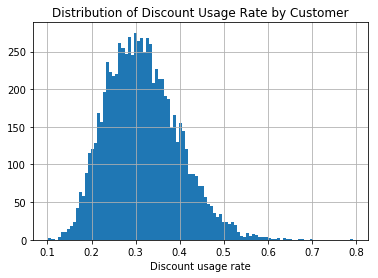

In [20]:
# plot the distribution of discount usage rate, select 0.4 as the cutoff threshold for cherry-picker
get_cherry_pickers['promo_percentage'].hist(bins=100)
plt.xlabel('Discount usage rate')
plt.title('Distribution of Discount Usage Rate by Customer')
plt.show()

In [21]:
# label the cherry pickers
get_cherry_pickers['cherry_pickers'] = np.where(get_cherry_pickers['promo_percentage']>=0.4, 1, 0)

In [22]:
get_cherry_pickers=get_cherry_pickers.reset_index().drop(['trans_on_promo','total_trans','promo_percentage'],axis=1)
get_cherry_pickers.shape

(7920, 2)

In [23]:
# Merge back to cust_full_list
cust_full_list=pd.merge(cust_full_list,get_cherry_pickers,left_on = 'cust_id', right_on = 'cust_id', how = 'left')

### Get a table of customers full list, identifying whether they buy private_label cola, coca-cola, pepsi cola, and whether they are cherry pickers

In [24]:
print(cust_full_list.head())
print(cust_full_list.shape)

   cust_id  Private_Label  COCA COLA Buyer  PEPSI COLA Buyer  cherry_pickers
0    29568            1.0              1.0               1.0               0
1    29909            1.0              1.0               1.0               0
2    39774            1.0              1.0               1.0               1
3    39856            1.0              1.0               1.0               0
4    59984            0.0              1.0               0.0               0
(7920, 5)


### Find the cola drink buyers and cluster them by their purchase history

#### Pepsi

In [25]:
# Get the whole transaction table with customer info
transactions_with_cust_info = pd.merge(transactions, cust_full_list, left_on = 'cust_id', right_on = 'cust_id', how = 'left')
transactions_with_cust_info.head()

,cust_id,trans_id,tran_dt,store_id,prod_id,prod_unit,tran_prod_sale_amt,tran_prod_sale_qty,tran_prod_discount_amt,tran_prod_offer_cts,tran_prod_paid_amt,prod_unit_price,Private_Label,COCA COLA Buyer,PEPSI COLA Buyer,cherry_pickers
0,29568,0,2016-03-01,192,230909010,CT,3.87,3.0,-1.95,1,1.92,1.29,1.0,1.0,1.0,0
1,29568,0,2016-03-01,192,266417009,CT,2.59,1.0,-1.30,1,1.29,2.59,1.0,1.0,1.0,0
2,29568,0,2016-03-01,192,486635012,CT,3.85,1.0,0.00,0,3.85,3.85,1.0,1.0,1.0,0
3,29568,0,2016-03-01,192,999194957,CT,0.99,1.0,0.00,0,0.99,0.99,1.0,1.0,1.0,0
4,29568,0,2016-03-01,192,999227294,CT,1.99,1.0,-1.00,1,0.99,1.99,1.0,1.0,1.0,0


In [26]:
# extract the pepsi-drinkers that are also cherry-pickers that also do not buy the private label cola
pepsi_cust_transactions = transactions_with_cust_info[(transactions_with_cust_info['PEPSI COLA Buyer']==1)&(transactions_with_cust_info['cherry_pickers']==1)&(transactions_with_cust_info['Private_Label']==0)]
pepsi_cust_transactions.head()

,cust_id,trans_id,tran_dt,store_id,prod_id,prod_unit,tran_prod_sale_amt,tran_prod_sale_qty,tran_prod_discount_amt,tran_prod_offer_cts,tran_prod_paid_amt,prod_unit_price,Private_Label,COCA COLA Buyer,PEPSI COLA Buyer,cherry_pickers
325795,1109886,29570,2016-01-05,670,999186855,KG,2.82,0.566,0.00,0,2.82,4.982332,0.0,1.0,1.0,1
325796,1109886,29570,2016-01-05,670,999245731,CT,2.98,1.000,-1.49,1,1.49,2.980000,0.0,1.0,1.0,1
325797,1109886,29570,2016-01-05,670,999304154,CT,11.67,3.000,-3.00,1,8.67,3.890000,0.0,1.0,1.0,1
325798,1109886,29570,2016-01-05,670,999530542,CT,1.39,1.000,-0.70,1,0.69,1.390000,0.0,1.0,1.0,1
325799,1109886,29570,2016-01-05,670,999982600,CT,1.89,1.000,-0.95,1,0.94,1.890000,0.0,1.0,1.0,1


In [27]:
# find the top 30 products that Pepsi-drinkers bought in their transaction history
pepsi_product_frequency = pepsi_cust_transactions['prod_id'].value_counts()
pepsi_top_product = pepsi_product_frequency[0:30].index.to_list()

In [28]:
# identify the pepsi products
Pepsi_prod = products[(products['category_desc_eng']=='COLA DRINK') & (products['brand_desc']=='PEPSI COLA')]
Pepsi_prod = Pepsi_prod['prod_id'].to_list()
Pepsi_prod

[999167784, 999225580, 999237426, 999349816, 999590416]

In [29]:
# check whether the top 30 products contain Pepsi products
Intersection = [prod in Pepsi_prod for prod in pepsi_top_product]
sum(Intersection)

0

In [30]:
# check if the transaction is about the top 30 products
for i in range(1,31):
    pepsi_cust_transactions['count'] = (pepsi_cust_transactions['prod_id']==pepsi_top_product[i-1]).astype(int)
    pepsi_cust_transactions.rename(columns = {'count':str(pepsi_top_product[i-1])}, inplace = True)

C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\richa\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [31]:
pepsi_cust_transactions.head()

,cust_id,trans_id,tran_dt,store_id,prod_id,prod_unit,tran_prod_sale_amt,tran_prod_sale_qty,tran_prod_discount_amt,tran_prod_offer_cts,...,999742491,999557956,999944032,999412624,999957157,999456026,999401863,999662852,999737260,999626930
325795,1109886,29570,2016-01-05,670,999186855,KG,2.82,0.566,0.00,0,...,0,0,0,0,0,0,0,0,0,0
325796,1109886,29570,2016-01-05,670,999245731,CT,2.98,1.000,-1.49,1,...,0,0,0,0,0,0,0,0,0,0
325797,1109886,29570,2016-01-05,670,999304154,CT,11.67,3.000,-3.00,1,...,0,0,0,0,0,0,0,0,0,0
325798,1109886,29570,2016-01-05,670,999530542,CT,1.39,1.000,-0.70,1,...,0,0,0,0,0,0,0,0,0,0
325799,1109886,29570,2016-01-05,670,999982600,CT,1.89,1.000,-0.95,1,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# get the customers' purchase history about the top 30 products
pepsi_cust_info = pepsi_cust_transactions.groupby(['cust_id']).sum()
pepsi_cust_info = pepsi_cust_info.iloc[:,-30:]
pepsi_cust_info[pepsi_cust_info>0] = 1
pepsi_cust_info.head()

,999231999,999956795,999361204,999746519,999401572,999401500,999455829,999712725,999957158,999356553,...,999742491,999557956,999944032,999412624,999957157,999456026,999401863,999662852,999737260,999626930
cust_id,,,,,,,,,,,,,,,,,,,,,
1109886,1,1,1,0,0,1,1,0,1,0,...,0,1,0,1,0,1,0,0,0,0
1249961,1,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,0,0,1,1,1
1609938,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,0,1,0,1,0
1639780,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
2009681,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,0,1,1,1,1


In [33]:
# the number of pepsi-drinkers
pepsi_cust_info.shape

(175, 30)

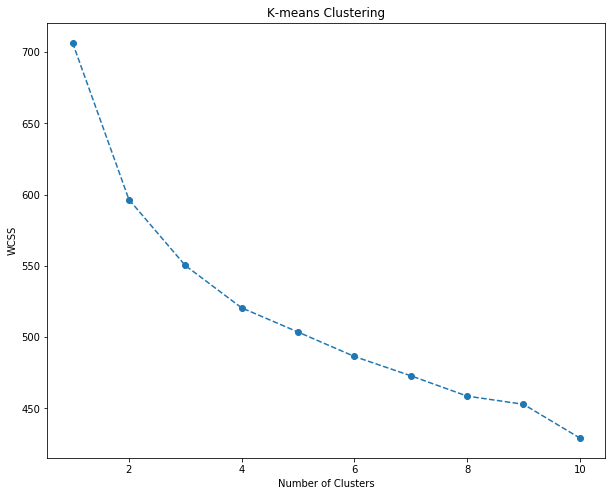

In [34]:
from sklearn.cluster import KMeans
#K-means Clustering
#K means doesn't tell us how many clusters there are, instead it minimizes the Euclidean norm.
# we calculate the within cluster sum of squares or WCSS for each of the clustering solutions. We will use within cluster sum of squares values to determine the best clustering solution.


wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(pepsi_cust_info)
    wcss.append(kmeans.inertia_)

    
    
plt.figure(figsize = (10,8))
plt.plot(range(1,11),wcss,marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.show()

#depending on the shape of this graph we make a decision about the number of cluster.
#We will use the Elbow method : find the only place until which the graph is steeply declining while smoothing out aferwards.n=5 in this case.


In [35]:
#fit the data using k means fit using our purchase history data
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
kmeans.fit(pepsi_cust_info)
pepsi_cust_info['Segment K-means'] = kmeans.labels_
#add a new column which will contain the predicted cluster for each observation
pepsi_cust_info.head()

,999231999,999956795,999361204,999746519,999401572,999401500,999455829,999712725,999957158,999356553,...,999557956,999944032,999412624,999957157,999456026,999401863,999662852,999737260,999626930,Segment K-means
cust_id,,,,,,,,,,,,,,,,,,,,,
1109886,1,1,1,0,0,1,1,0,1,0,...,1,0,1,0,1,0,0,0,0,0
1249961,1,1,1,0,1,1,1,1,1,1,...,1,1,1,1,0,0,1,1,1,4
1609938,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,0,1,0,1,0,1
1639780,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,3
2009681,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,2


In [36]:
# find the customer number in each cluster
pepsi_cust_info['Segment K-means'].value_counts()

4    75
2    41
1    24
0    23
3    12
Name: Segment K-means, dtype: int64

#### Coca-cola

In [37]:
# now we repeat the process for Coke products, and find the transactions of coke products
coca_cola_cust_transactions = transactions_with_cust_info[(transactions_with_cust_info['COCA COLA Buyer']==1)&(transactions_with_cust_info['cherry_pickers']==1)&(transactions_with_cust_info['Private_Label']==0)]
coca_cola_cust_transactions.head()

,cust_id,trans_id,tran_dt,store_id,prod_id,prod_unit,tran_prod_sale_amt,tran_prod_sale_qty,tran_prod_discount_amt,tran_prod_offer_cts,tran_prod_paid_amt,prod_unit_price,Private_Label,COCA COLA Buyer,PEPSI COLA Buyer,cherry_pickers
57165,229838,5222,2016-01-06,509,234415008,CT,1.68,4.0,-0.84,1,0.84,0.4200,0.0,1.0,0.0,1
57166,229838,5222,2016-01-06,509,234416007,CT,1.40,4.0,-0.70,1,0.70,0.3500,0.0,1.0,0.0,1
57167,229838,5222,2016-01-06,509,999186966,CT,2.69,4.0,-1.40,1,1.29,0.6725,0.0,1.0,0.0,1
57168,229838,5222,2016-01-06,509,999194957,CT,0.99,1.0,-0.50,1,0.49,0.9900,0.0,1.0,0.0,1
57169,229838,5222,2016-01-06,509,999195553,CT,1.59,1.0,-0.80,1,0.79,1.5900,0.0,1.0,0.0,1


In [38]:
# find the top 30 products that Coke-drinkers bought according to their purchase history
coca_cola_product_frequency = coca_cola_cust_transactions['prod_id'].value_counts()
coca_cola_top_product = coca_cola_product_frequency[0:30].index.to_list()

In [39]:
# find the coke products
coca_cola_prod = products[(products['category_desc_eng']=='COLA DRINK') & (products['brand_desc']=='COCA COLA')]
coca_cola_prod = coca_cola_prod['prod_id'].to_list()
coca_cola_prod

[999153856,
 999153857,
 999165545,
 999165976,
 999224991,
 999245271,
 999248329,
 999261787,
 999266066,
 999279092,
 999279093,
 999279094,
 999289563,
 999298467,
 999329592,
 999329593,
 999335824,
 999341136,
 999422862,
 999449211,
 999642204]

In [40]:
# check if any of the top 30 products is coke product
Intersection = [prod in coca_cola_prod for prod in coca_cola_top_product]
sum(Intersection)

0

In [41]:
# determine whether the transaction is about coke products
for i in range(1,31):
    coca_cola_cust_transactions['count'] = (coca_cola_cust_transactions['prod_id']==coca_cola_top_product[i-1]).astype(int)
    coca_cola_cust_transactions.rename(columns = {'count':str(coca_cola_top_product[i-1])}, inplace = True)

C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\richa\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [42]:
coca_cola_cust_transactions.head()

,cust_id,trans_id,tran_dt,store_id,prod_id,prod_unit,tran_prod_sale_amt,tran_prod_sale_qty,tran_prod_discount_amt,tran_prod_offer_cts,...,999747259,999626930,999944032,999953459,999737260,999401863,999412624,999456026,999951863,999953515
57165,229838,5222,2016-01-06,509,234415008,CT,1.68,4.0,-0.84,1,...,0,0,0,0,0,0,0,0,0,0
57166,229838,5222,2016-01-06,509,234416007,CT,1.40,4.0,-0.70,1,...,0,0,0,0,0,0,0,0,0,0
57167,229838,5222,2016-01-06,509,999186966,CT,2.69,4.0,-1.40,1,...,0,0,0,0,0,0,0,0,0,0
57168,229838,5222,2016-01-06,509,999194957,CT,0.99,1.0,-0.50,1,...,0,0,0,0,0,0,0,0,0,0
57169,229838,5222,2016-01-06,509,999195553,CT,1.59,1.0,-0.80,1,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# Get the info about whether a certain customer has bought the top 30 products before
coca_cola_cust_info = coca_cola_cust_transactions.groupby(['cust_id']).sum()
coca_cola_cust_info = coca_cola_cust_info.iloc[:,-30:]
coca_cola_cust_info[coca_cola_cust_info>0] = 1
coca_cola_cust_info.head()

,999956795,999231999,999361204,999746519,999401500,999455829,999957158,999504322,999712725,999953571,...,999747259,999626930,999944032,999953459,999737260,999401863,999412624,999456026,999951863,999953515
cust_id,,,,,,,,,,,,,,,,,,,,,
229838,1,1,1,0,0,1,1,1,1,1,...,1,1,0,1,1,1,1,1,1,1
339665,1,1,1,1,0,1,1,1,1,1,...,1,1,0,1,1,1,0,1,1,1
529915,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
749556,1,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
819740,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1


In [46]:
# the number of coke-drinkers
coca_cola_cust_info.shape

(622, 31)

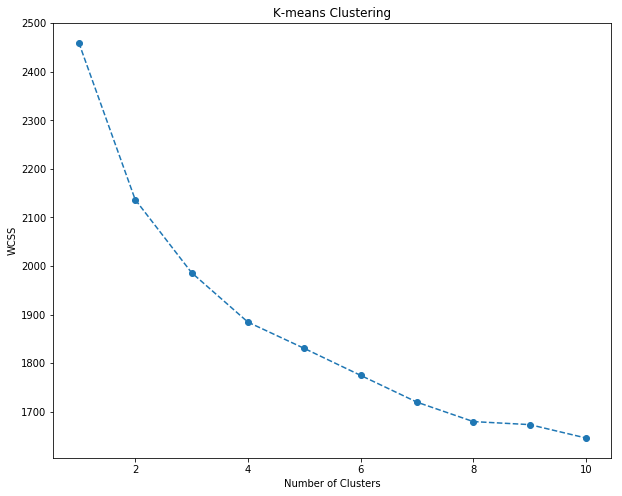

In [44]:
from sklearn.cluster import KMeans
#K-means Clustering
#K means doesn't tell us how many clusters there are, instead it minimizes the Euclidean norm.
# we calculate the within cluster sum of squares or WCSS for each of the clustering solutions. We will use within cluster sum of squares values to determine the best clustering solution.


wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(coca_cola_cust_info)
    wcss.append(kmeans.inertia_)

    
    
plt.figure(figsize = (10,8))
plt.plot(range(1,11),wcss,marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.show()

#depending on the shape of this graph we make a decision about the number of cluster.
#We will use the Elbow method : find the only place until which the graph is steeply declining while smoothing out aferwards.n=5 in this case.


In [45]:
# fit the data using k means fit using ourdata
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
kmeans.fit(coca_cola_cust_info)
coca_cola_cust_info['Segment K-means'] = kmeans.labels_
#add a new column which will contain the predicted cluster for each observation
coca_cola_cust_info.head()

,999956795,999231999,999361204,999746519,999401500,999455829,999957158,999504322,999712725,999953571,...,999626930,999944032,999953459,999737260,999401863,999412624,999456026,999951863,999953515,Segment K-means
cust_id,,,,,,,,,,,,,,,,,,,,,
229838,1,1,1,0,0,1,1,1,1,1,...,1,0,1,1,1,1,1,1,1,1
339665,1,1,1,1,0,1,1,1,1,1,...,1,0,1,1,1,0,1,1,1,1
529915,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,2
749556,1,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,2
819740,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,2


In [47]:
# find the customer number in each cluster
coca_cola_cust_info['Segment K-means'].value_counts()

2    301
0    124
1     94
3     73
4     30
Name: Segment K-means, dtype: int64

### Calculate non-coke buyers' similarity with the buyers and decide whether they'll buy the coke during the promotion

### Pepsi

In [48]:
# pull the customers that are cherry pickers but don't buy Pepsi or private label cola
no_pepsi_cust_transactions = transactions_with_cust_info[(transactions_with_cust_info['PEPSI COLA Buyer']==0)&(transactions_with_cust_info['cherry_pickers']==1)&(transactions_with_cust_info['Private_Label']==0)]
no_pepsi_cust_transactions.head()

,cust_id,trans_id,tran_dt,store_id,prod_id,prod_unit,tran_prod_sale_amt,tran_prod_sale_qty,tran_prod_discount_amt,tran_prod_offer_cts,tran_prod_paid_amt,prod_unit_price,Private_Label,COCA COLA Buyer,PEPSI COLA Buyer,cherry_pickers
57165,229838,5222,2016-01-06,509,234415008,CT,1.68,4.0,-0.84,1,0.84,0.4200,0.0,1.0,0.0,1
57166,229838,5222,2016-01-06,509,234416007,CT,1.40,4.0,-0.70,1,0.70,0.3500,0.0,1.0,0.0,1
57167,229838,5222,2016-01-06,509,999186966,CT,2.69,4.0,-1.40,1,1.29,0.6725,0.0,1.0,0.0,1
57168,229838,5222,2016-01-06,509,999194957,CT,0.99,1.0,-0.50,1,0.49,0.9900,0.0,1.0,0.0,1
57169,229838,5222,2016-01-06,509,999195553,CT,1.59,1.0,-0.80,1,0.79,1.5900,0.0,1.0,0.0,1


In [49]:
# find whether the non-Pepsi-drinkers have bought the top 30 products or not
for i in range(1,31):
    no_pepsi_cust_transactions['count'] = (no_pepsi_cust_transactions['prod_id']==pepsi_top_product[i-1]).astype(int)
    no_pepsi_cust_transactions.rename(columns = {'count':str(pepsi_top_product[i-1])}, inplace = True)

C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\richa\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [50]:
no_pepsi_cust_transactions.head()

,cust_id,trans_id,tran_dt,store_id,prod_id,prod_unit,tran_prod_sale_amt,tran_prod_sale_qty,tran_prod_discount_amt,tran_prod_offer_cts,...,999742491,999557956,999944032,999412624,999957157,999456026,999401863,999662852,999737260,999626930
57165,229838,5222,2016-01-06,509,234415008,CT,1.68,4.0,-0.84,1,...,0,0,0,0,0,0,0,0,0,0
57166,229838,5222,2016-01-06,509,234416007,CT,1.40,4.0,-0.70,1,...,0,0,0,0,0,0,0,0,0,0
57167,229838,5222,2016-01-06,509,999186966,CT,2.69,4.0,-1.40,1,...,0,0,0,0,0,0,0,0,0,0
57168,229838,5222,2016-01-06,509,999194957,CT,0.99,1.0,-0.50,1,...,0,0,0,0,0,0,0,0,0,0
57169,229838,5222,2016-01-06,509,999195553,CT,1.59,1.0,-0.80,1,...,0,0,0,0,0,0,0,0,0,0


In [51]:
# find whether those non-Pepsi-drinkers will buy the top 30 products or not
no_pepsi_cust_info = no_pepsi_cust_transactions.groupby(['cust_id']).sum()
no_pepsi_cust_info = no_pepsi_cust_info.iloc[:,-30:]
no_pepsi_cust_info[no_pepsi_cust_info>0] = 1
no_pepsi_cust_info.head()

,999231999,999956795,999361204,999746519,999401572,999401500,999455829,999712725,999957158,999356553,...,999742491,999557956,999944032,999412624,999957157,999456026,999401863,999662852,999737260,999626930
cust_id,,,,,,,,,,,,,,,,,,,,,
229838,1,1,1,0,1,0,1,1,1,1,...,0,1,0,1,1,1,1,1,1,1
339665,1,1,1,1,1,0,1,1,1,1,...,1,1,0,0,1,1,1,1,1,1
399566,1,1,1,0,0,0,1,1,0,0,...,0,0,0,1,1,0,1,0,1,1
529915,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
749556,1,1,1,0,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1


In [52]:
# We have 574 non-Pepsi-drinkers
no_pepsi_cust_info.shape

(574, 30)

In [53]:
# calculate the average purchase preference for each pepsi-drinkers' cluster
pepsi_cluster = pepsi_cust_info.groupby(['Segment K-means']).mean()
pepsi_cluster.head()

,999231999,999956795,999361204,999746519,999401572,999401500,999455829,999712725,999957158,999356553,...,999742491,999557956,999944032,999412624,999957157,999456026,999401863,999662852,999737260,999626930
Segment K-means,,,,,,,,,,,,,,,,,,,,,
0,1.000000,1.000000,1.000000,0.478261,0.652174,0.652174,0.869565,0.826087,0.869565,0.826087,...,0.173913,0.391304,0.695652,0.739130,0.782609,0.913043,0.826087,0.434783,0.869565,0.869565
1,0.958333,1.000000,0.916667,0.791667,0.541667,0.708333,0.750000,1.000000,0.916667,0.833333,...,0.833333,0.750000,0.875000,0.708333,0.708333,0.125000,0.791667,0.541667,0.791667,0.875000
2,0.951220,0.975610,1.000000,0.560976,0.902439,0.902439,0.902439,0.780488,0.804878,0.951220,...,0.000000,0.951220,0.926829,0.829268,0.756098,0.902439,0.780488,0.853659,0.853659,0.926829
3,1.000000,0.333333,0.250000,0.166667,0.666667,0.416667,0.583333,0.750000,0.500000,0.250000,...,0.166667,0.000000,0.500000,0.083333,0.000000,0.666667,0.750000,0.750000,0.000000,0.000000
4,0.986667,1.000000,0.986667,0.746667,0.920000,0.813333,1.000000,0.986667,0.853333,0.946667,...,1.000000,0.960000,0.920000,0.893333,0.880000,0.973333,0.866667,0.933333,0.933333,0.960000


In [54]:
# calculate the similarity score for each non-Pepsi-drinker
for i in range(1,6):
    cluster_vector = pepsi_cluster.iloc[i-1,:].values
    score = np.array([])
    for j in range(0,no_pepsi_cust_info.shape[0]):
        cust_vector = no_pepsi_cust_info.iloc[j,:].values[0:30]
        temp = sum(cluster_vector * cust_vector) / ((np.linalg.norm(cluster_vector))*(np.linalg.norm(cust_vector)))
        score = np.append(score, temp)
    no_pepsi_cust_info['score'] = score
    no_pepsi_cust_info.rename(columns = {'score':str('Cluster '+str(i-1)+' Similarity')}, inplace = True)

In [55]:
no_pepsi_cust_info.head()

,999231999,999956795,999361204,999746519,999401572,999401500,999455829,999712725,999957158,999356553,...,999456026,999401863,999662852,999737260,999626930,Cluster 0 Similarity,Cluster 1 Similarity,Cluster 2 Similarity,Cluster 3 Similarity,Cluster 4 Similarity
cust_id,,,,,,,,,,,,,,,,,,,,,
229838,1,1,1,0,1,0,1,1,1,1,...,1,1,1,1,1,0.936721,0.902339,0.953076,0.750410,0.938500
339665,1,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,0.915231,0.925803,0.924487,0.754640,0.953112
399566,1,1,1,0,0,0,1,1,0,0,...,0,1,0,1,1,0.827075,0.773985,0.742957,0.553399,0.744052
529915,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0.958866,0.973950,0.978314,0.785196,0.998101
749556,1,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,0.926583,0.911680,0.955072,0.744208,0.932868


In [56]:
no_pepsi_cust_similarity = no_pepsi_cust_info.iloc[:,-5:]
no_pepsi_cust_similarity.describe()

,Cluster 0 Similarity,Cluster 1 Similarity,Cluster 2 Similarity,Cluster 3 Similarity,Cluster 4 Similarity
count,574.000000,574.000000,574.000000,574.000000,574.000000
mean,0.884665,0.882214,0.892662,0.726674,0.897918
std,0.086842,0.096092,0.092114,0.077405,0.094061
min,0.482485,0.434464,0.471586,0.252982,0.455104
25%,0.864441,0.867432,0.863321,0.689377,0.876572
50%,0.911012,0.909812,0.920570,0.743085,0.922626
75%,0.939603,0.938636,0.955072,0.775195,0.959004
max,0.976890,0.985293,0.995039,0.938971,0.998101


In [57]:
# find the cluster to which each non-pepsi-drinker is most similar
no_pepsi_cust_similarity['max_value']=no_pepsi_cust_similarity.max(axis=1)
no_pepsi_array = no_pepsi_cust_similarity.values
no_pepsi_cust_similarity['max_index']=np.argmax(no_pepsi_array,axis=1)
no_pepsi_cust_similarity.head()

,Cluster 0 Similarity,Cluster 1 Similarity,Cluster 2 Similarity,Cluster 3 Similarity,Cluster 4 Similarity,max_value,max_index
cust_id,,,,,,,
229838,0.936721,0.902339,0.953076,0.750410,0.938500,0.953076,2
339665,0.915231,0.925803,0.924487,0.754640,0.953112,0.953112,4
399566,0.827075,0.773985,0.742957,0.553399,0.744052,0.827075,0
529915,0.958866,0.973950,0.978314,0.785196,0.998101,0.998101,4
749556,0.926583,0.911680,0.955072,0.744208,0.932868,0.955072,2


In [112]:
no_pepsi_cust_similarity.to_csv('1.csv')

In [58]:
# set threshold requirements for each pepsi cluster
Cluster0_cond = (no_pepsi_cust_similarity['max_index']==0) & (no_pepsi_cust_similarity['max_value']>0.9)
Cluster1_cond = (no_pepsi_cust_similarity['max_index']==1) & (no_pepsi_cust_similarity['max_value']>0.9)
Cluster2_cond = (no_pepsi_cust_similarity['max_index']==2) & (no_pepsi_cust_similarity['max_value']>0.9)
Cluster3_cond = (no_pepsi_cust_similarity['max_index']==3) & (no_pepsi_cust_similarity['max_value']>0.8)
Cluster4_cond = (no_pepsi_cust_similarity['max_index']==4) & (no_pepsi_cust_similarity['max_value']>0.9)
InCluster = Cluster0_cond | Cluster1_cond | Cluster2_cond | Cluster3_cond | Cluster4_cond
# filter out those who are not that similar
no_pepsi_cust_cluster = no_pepsi_cust_similarity[InCluster]
no_pepsi_cust_cluster.head()

,Cluster 0 Similarity,Cluster 1 Similarity,Cluster 2 Similarity,Cluster 3 Similarity,Cluster 4 Similarity,max_value,max_index
cust_id,,,,,,,
229838,0.936721,0.902339,0.953076,0.750410,0.938500,0.953076,2
339665,0.915231,0.925803,0.924487,0.754640,0.953112,0.953112,4
529915,0.958866,0.973950,0.978314,0.785196,0.998101,0.998101,4
749556,0.926583,0.911680,0.955072,0.744208,0.932868,0.955072,2
789747,0.877895,0.861405,0.881887,0.729412,0.908609,0.908609,4


In [59]:
no_pepsi_cust_cluster = pd.DataFrame(no_pepsi_cust_cluster.iloc[:,-1])
no_pepsi_cust_cluster.rename(columns = {'max_index':'Segment K-means'}, inplace = True)
pepsi_cust_cluster = pd.DataFrame(pepsi_cust_info.iloc[:,-1])

In [60]:
# get our Pepsi target customers
pepsi_cust_cluster['pepsi-buyer'] = 1
no_pepsi_cust_cluster['pepsi-buyer'] = 0
pepsi_target_cust = pd.concat([pepsi_cust_cluster, no_pepsi_cust_cluster])
pepsi_target_cust

,Segment K-means,pepsi-buyer
cust_id,,
1109886,0,1
1249961,4,1
1609938,1,1
1639780,3,1
2009681,2,1
2689745,2,1
2899928,4,1
3259598,2,1
4229650,0,1


### Coca-Cola

In [61]:
# now we repeat the same process above for Coke products
no_coca_cola_cust_transactions = transactions_with_cust_info[(transactions_with_cust_info['COCA COLA Buyer']==0)&(transactions_with_cust_info['cherry_pickers']==1)&(transactions_with_cust_info['Private_Label']==0)]
no_coca_cola_cust_transactions.head()

,cust_id,trans_id,tran_dt,store_id,prod_id,prod_unit,tran_prod_sale_amt,tran_prod_sale_qty,tran_prod_discount_amt,tran_prod_offer_cts,tran_prod_paid_amt,prod_unit_price,Private_Label,COCA COLA Buyer,PEPSI COLA Buyer,cherry_pickers
113074,399566,9965,2016-03-24,578,999309673,CT,1.39,1.000,-0.44,1,0.95,1.390000,0.0,0.0,0.0,1
113075,399566,9965,2016-03-24,578,999316009,CT,7.98,2.000,-4.00,1,3.98,3.990000,0.0,0.0,0.0,1
113076,399566,9965,2016-03-24,578,999443025,CT,1.98,2.000,0.00,0,1.98,0.990000,0.0,0.0,0.0,1
113077,399566,9965,2016-03-24,578,999530159,KG,2.17,1.096,0.00,0,2.17,1.979927,0.0,0.0,0.0,1
113078,399566,9965,2016-03-24,578,999696393,KG,5.54,0.584,0.00,0,5.54,9.486301,0.0,0.0,0.0,1


In [62]:
for i in range(1,31):
    no_coca_cola_cust_transactions['count'] = (no_coca_cola_cust_transactions['prod_id']==coca_cola_top_product[i-1]).astype(int)
    no_coca_cola_cust_transactions.rename(columns = {'count':str(coca_cola_top_product[i-1])}, inplace = True)

C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\richa\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [63]:
no_coca_cola_cust_transactions.head()

,cust_id,trans_id,tran_dt,store_id,prod_id,prod_unit,tran_prod_sale_amt,tran_prod_sale_qty,tran_prod_discount_amt,tran_prod_offer_cts,...,999747259,999626930,999944032,999953459,999737260,999401863,999412624,999456026,999951863,999953515
113074,399566,9965,2016-03-24,578,999309673,CT,1.39,1.000,-0.44,1,...,0,0,0,0,0,0,0,0,0,0
113075,399566,9965,2016-03-24,578,999316009,CT,7.98,2.000,-4.00,1,...,0,0,0,0,0,0,0,0,0,0
113076,399566,9965,2016-03-24,578,999443025,CT,1.98,2.000,0.00,0,...,0,0,0,0,0,0,0,0,0,0
113077,399566,9965,2016-03-24,578,999530159,KG,2.17,1.096,0.00,0,...,0,0,0,0,0,0,0,0,0,0
113078,399566,9965,2016-03-24,578,999696393,KG,5.54,0.584,0.00,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
# get non-Coke-drinkers purchase history for the 30 products
no_coca_cola_cust_info = no_coca_cola_cust_transactions.groupby(['cust_id']).sum()
no_coca_cola_cust_info = no_coca_cola_cust_info.iloc[:,-30:]
no_coca_cola_cust_info[no_coca_cola_cust_info>0] = 1
no_coca_cola_cust_info.head()

,999956795,999231999,999361204,999746519,999401500,999455829,999957158,999504322,999712725,999953571,...,999747259,999626930,999944032,999953459,999737260,999401863,999412624,999456026,999951863,999953515
cust_id,,,,,,,,,,,,,,,,,,,,,
399566,1,1,1,0,0,1,0,1,1,1,...,0,1,0,1,1,1,1,0,0,1
789747,1,1,1,0,0,1,0,1,1,1,...,1,1,1,0,1,0,1,1,1,1
1369928,1,1,1,0,1,1,1,1,1,1,...,0,1,1,1,1,0,0,1,1,1
1879807,1,1,1,1,1,1,1,0,1,1,...,1,1,1,1,1,0,1,1,1,1
1889991,1,1,1,1,0,1,0,1,1,0,...,0,0,1,0,1,1,0,1,1,1


In [65]:
# we have 127 non-Coke-drinkers
no_coca_cola_cust_info.shape

(127, 30)

In [66]:
coca_cola_cluster = coca_cola_cust_info.groupby(['Segment K-means']).mean()
coca_cola_cluster.head()

,999956795,999231999,999361204,999746519,999401500,999455829,999957158,999504322,999712725,999953571,...,999747259,999626930,999944032,999953459,999737260,999401863,999412624,999456026,999951863,999953515
Segment K-means,,,,,,,,,,,,,,,,,,,,,
0,0.991935,0.975806,1.000000,0.629032,0.693548,0.903226,0.870968,0.911290,0.903226,0.959677,...,0.774194,0.879032,0.903226,0.846774,0.879032,0.758065,0.862903,0.822581,0.000000,0.943548
1,1.000000,0.978723,0.989362,0.680851,0.000000,0.936170,0.851064,0.936170,0.861702,0.861702,...,0.808511,0.936170,0.819149,0.861702,0.829787,0.893617,0.808511,0.882979,0.978723,0.829787
2,0.993355,0.973422,0.990033,0.700997,1.000000,0.973422,0.913621,0.910299,0.923588,0.926910,...,0.900332,0.900332,0.903654,0.877076,0.900332,0.817276,0.807309,0.906977,1.000000,0.873754
3,0.986301,0.958904,0.958904,0.465753,0.589041,0.410959,0.808219,0.726027,0.767123,0.794521,...,0.589041,0.767123,0.643836,0.712329,0.465753,0.643836,0.452055,0.246575,0.534247,0.753425
4,0.066667,0.966667,0.033333,0.100000,0.433333,0.533333,0.666667,0.000000,0.933333,0.900000,...,0.100000,0.066667,0.400000,0.833333,0.000000,0.866667,0.000000,0.833333,0.566667,0.900000


In [67]:
# calculate the similarity
for i in range(1,6):
    cluster_vector = coca_cola_cluster.iloc[i-1,:].values
    score = np.array([])
    for j in range(0,no_coca_cola_cust_info.shape[0]):
        cust_vector = no_coca_cola_cust_info.iloc[j,:].values[0:30]
        temp = sum(cluster_vector * cust_vector) / ((np.linalg.norm(cluster_vector))*(np.linalg.norm(cust_vector)))
        score = np.append(score, temp)
    no_coca_cola_cust_info['score'] = score
    no_coca_cola_cust_info.rename(columns = {'score':str('Cluster '+str(i-1)+' Similarity')}, inplace = True)

In [68]:
no_coca_cola_cust_info.head()

,999956795,999231999,999361204,999746519,999401500,999455829,999957158,999504322,999712725,999953571,...,999401863,999412624,999456026,999951863,999953515,Cluster 0 Similarity,Cluster 1 Similarity,Cluster 2 Similarity,Cluster 3 Similarity,Cluster 4 Similarity
cust_id,,,,,,,,,,,,,,,,,,,,,
399566,1,1,1,0,0,1,0,1,1,1,...,1,1,0,0,1,0.822383,0.802348,0.776447,0.819583,0.576295
789747,1,1,1,0,0,1,0,1,1,1,...,0,1,1,1,1,0.867998,0.891418,0.882310,0.868236,0.636699
1369928,1,1,1,0,1,1,1,1,1,1,...,0,0,1,1,1,0.912501,0.901680,0.930474,0.917079,0.679293
1879807,1,1,1,1,1,1,1,0,1,1,...,0,1,1,1,1,0.907960,0.902472,0.932005,0.903545,0.709496
1889991,1,1,1,1,0,1,0,1,1,0,...,1,0,1,1,1,0.787887,0.837689,0.814599,0.782400,0.615990


In [69]:
no_coca_cola_cust_similarity = no_coca_cola_cust_info.iloc[:,-5:]
no_coca_cola_cust_similarity.describe()

,Cluster 0 Similarity,Cluster 1 Similarity,Cluster 2 Similarity,Cluster 3 Similarity,Cluster 4 Similarity
count,127.000000,127.000000,127.000000,127.000000,127.000000
mean,0.885442,0.882285,0.894112,0.878887,0.680525
std,0.103716,0.102578,0.100922,0.091287,0.097760
min,0.511731,0.531205,0.543184,0.565605,0.258893
25%,0.849362,0.847009,0.867685,0.854406,0.613928
50%,0.919393,0.912059,0.924736,0.910539,0.698323
75%,0.957295,0.950057,0.960519,0.939000,0.735241
max,0.986618,0.996044,0.997676,0.963878,0.951216


In [70]:
# find which cluster is most similar to each non-Coke-drinker
no_coca_cola_cust_similarity['max_value']=no_coca_cola_cust_similarity.max(axis=1)
no_coca_cola_array = no_coca_cola_cust_similarity.values
no_coca_cola_cust_similarity['max_index']=np.argmax(no_coca_cola_array,axis=1)
no_coca_cola_cust_similarity.head()

,Cluster 0 Similarity,Cluster 1 Similarity,Cluster 2 Similarity,Cluster 3 Similarity,Cluster 4 Similarity,max_value,max_index
cust_id,,,,,,,
399566,0.822383,0.802348,0.776447,0.819583,0.576295,0.822383,0
789747,0.867998,0.891418,0.882310,0.868236,0.636699,0.891418,1
1369928,0.912501,0.901680,0.930474,0.917079,0.679293,0.930474,2
1879807,0.907960,0.902472,0.932005,0.903545,0.709496,0.932005,2
1889991,0.787887,0.837689,0.814599,0.782400,0.615990,0.837689,1


In [71]:
# set the threshold
Cluster0_cond = (no_coca_cola_cust_similarity['max_index']==0) & (no_coca_cola_cust_similarity['max_value']>0.9)
Cluster1_cond = (no_coca_cola_cust_similarity['max_index']==1) & (no_coca_cola_cust_similarity['max_value']>0.9)
Cluster2_cond = (no_coca_cola_cust_similarity['max_index']==2) & (no_coca_cola_cust_similarity['max_value']>0.9)
Cluster3_cond = (no_coca_cola_cust_similarity['max_index']==3) & (no_coca_cola_cust_similarity['max_value']>0.9)
Cluster4_cond = (no_coca_cola_cust_similarity['max_index']==4) & (no_coca_cola_cust_similarity['max_value']>0.75)
InCluster = Cluster0_cond | Cluster1_cond | Cluster2_cond | Cluster3_cond | Cluster4_cond
# filter out the outliers
no_coca_cola_cust_cluster = no_coca_cola_cust_similarity[InCluster]
no_coca_cola_cust_cluster.head()

,Cluster 0 Similarity,Cluster 1 Similarity,Cluster 2 Similarity,Cluster 3 Similarity,Cluster 4 Similarity,max_value,max_index
cust_id,,,,,,,
1369928,0.912501,0.901680,0.930474,0.917079,0.679293,0.930474,2
1879807,0.907960,0.902472,0.932005,0.903545,0.709496,0.932005,2
1979557,0.925339,0.905759,0.886026,0.905581,0.643618,0.925339,0
3389801,0.977701,0.979303,0.997676,0.963878,0.735241,0.997676,2
4669939,0.911001,0.943434,0.924087,0.911383,0.755060,0.943434,1


In [72]:
no_coca_cola_cust_cluster = pd.DataFrame(no_coca_cola_cust_cluster.iloc[:,-1])
no_coca_cola_cust_cluster.rename(columns = {'max_index':'Segment K-means'}, inplace = True)
coca_cola_cust_cluster = pd.DataFrame(coca_cola_cust_info.iloc[:,-1])

In [73]:
# get our target customers for Coca-Cola
coca_cola_cust_cluster['coke-buyer'] = 1
no_coca_cola_cust_cluster['coke-buyer'] = 0
coca_cola_target_cust = pd.concat([coca_cola_cust_cluster, no_coca_cola_cust_cluster])
coca_cola_target_cust

,Segment K-means,coke-buyer
cust_id,,
229838,1,1
339665,1,1
529915,2,1
749556,2,1
819740,2,1
1109886,0,1
1129755,3,1
1249961,2,1
1539975,0,1


# Promotion Design

In [74]:
# get the segment value into our table that contains transaction info
coke_with_segments = transactions_with_cust_info[(transactions_with_cust_info['COCA COLA Buyer']==1)&(transactions_with_cust_info['cherry_pickers']==1)&(transactions_with_cust_info['Private_Label']==0)]
print(coke_with_segments.shape)
coke_with_segments = pd.merge(coke_with_segments, coca_cola_cust_cluster, left_on = 'cust_id', right_on = 'cust_id', how = 'left')
print(coke_with_segments.shape)

(2018663, 16)
(2018663, 18)


In [75]:
coke_with_segments.head()

,cust_id,trans_id,tran_dt,store_id,prod_id,prod_unit,tran_prod_sale_amt,tran_prod_sale_qty,tran_prod_discount_amt,tran_prod_offer_cts,tran_prod_paid_amt,prod_unit_price,Private_Label,COCA COLA Buyer,PEPSI COLA Buyer,cherry_pickers,Segment K-means,coke-buyer
0,229838,5222,2016-01-06,509,234415008,CT,1.68,4.0,-0.84,1,0.84,0.4200,0.0,1.0,0.0,1,1,1
1,229838,5222,2016-01-06,509,234416007,CT,1.40,4.0,-0.70,1,0.70,0.3500,0.0,1.0,0.0,1,1,1
2,229838,5222,2016-01-06,509,999186966,CT,2.69,4.0,-1.40,1,1.29,0.6725,0.0,1.0,0.0,1,1,1
3,229838,5222,2016-01-06,509,999194957,CT,0.99,1.0,-0.50,1,0.49,0.9900,0.0,1.0,0.0,1,1,1
4,229838,5222,2016-01-06,509,999195553,CT,1.59,1.0,-0.80,1,0.79,1.5900,0.0,1.0,0.0,1,1,1


In [76]:
# filter out all the transactions not involving a coke product
coke_with_segments = coke_with_segments[coke_with_segments['prod_id'].isin(coca_cola_prod)]
print(coke_with_segments.shape)

(7429, 18)


In [77]:
# get the highest frequency products sold within each cluster
coke_with_segments['disc_price'] = coke_with_segments['tran_prod_paid_amt']/coke_with_segments['tran_prod_sale_qty']
freq_by_cluster = coke_with_segments.groupby(['Segment K-means', 'prod_id']).agg({'coke-buyer':'sum', 'tran_prod_sale_qty':'sum', 'prod_unit_price':'mean', 'disc_price':'mean'})
g = freq_by_cluster['coke-buyer'].groupby(level = 0, group_keys = False)
g.nlargest(1)

Segment K-means  prod_id  
0                999422862    440
1                999422862    228
2                999422862    740
3                999329593    258
4                999422862     52
Name: coke-buyer, dtype: int64

In [78]:
# get the exact values we wish to merge into our target table
temp = freq_by_cluster.loc[[(0, 999422862), (1, 999422862), (2, 999422862), (3, 999329593), (4, 999422862)]]
temp['quantity'] = temp['tran_prod_sale_qty']/temp['coke-buyer']
temp['merger'] = 0
temp

,,coke-buyer,tran_prod_sale_qty,prod_unit_price,disc_price,quantity,merger
Segment K-means,prod_id,,,,,,
0,999422862,440,1363.0,1.777625,1.378040,3.097727,0
1,999422862,228,646.0,1.761316,1.418465,2.833333,0
2,999422862,740,2114.0,1.765277,1.391959,2.856757,0
3,999329593,258,375.0,1.083140,1.006370,1.453488,0
4,999422862,52,211.0,1.868077,1.485179,4.057692,0


In [79]:
# merge all of the above information into our table (All of the top rows should be Nan, the bottom should not)
coca_cola_target_cust2 = pd.merge(coca_cola_target_cust, temp, left_on = ['Segment K-means', 'coke-buyer'], right_on = ['Segment K-means', 'merger'], how = 'left')
coca_cola_target_cust2 = coca_cola_target_cust2.drop(['coke-buyer_y', 'tran_prod_sale_qty', 'merger'], axis = 1)
coca_cola_target_cust2['cust_id']  = coca_cola_target_cust.index
coca_cola_target_cust2 = coca_cola_target_cust2.rename(columns = {'coke-buyer_x':'coke_buyer'})
coca_cola_target_cust2

,Segment K-means,coke_buyer,prod_unit_price,disc_price,quantity,cust_id
0,1,1,NaN,NaN,NaN,229838
1,1,1,NaN,NaN,NaN,339665
2,2,1,NaN,NaN,NaN,529915
3,2,1,NaN,NaN,NaN,749556
4,2,1,NaN,NaN,NaN,819740
5,0,1,NaN,NaN,NaN,1109886
6,3,1,NaN,NaN,NaN,1129755
7,2,1,NaN,NaN,NaN,1249961
8,0,1,NaN,NaN,NaN,1539975
9,2,1,NaN,NaN,NaN,1609938


In [80]:
# get the customer id for the coke-drinkers
coke_cust_list = coca_cola_target_cust2['cust_id'][coca_cola_target_cust2['coke_buyer'] == 1]
print(len(coke_cust_list))
print(coca_cola_cust_cluster.shape)

622
(622, 2)


In [81]:
# we want to get the coke products purchased by those in our list
coke_with_segments = coke_with_segments[coke_with_segments['prod_id'].isin(coca_cola_prod)]
coke_with_segments = coke_with_segments[coke_with_segments['cust_id'].isin(coke_cust_list)]
print(coke_with_segments.shape)
coke_with_segments['disc_price'] = coke_with_segments['tran_prod_paid_amt']/coke_with_segments['tran_prod_sale_qty']

(7429, 19)


In [82]:
coke_with_segments.head()

,cust_id,trans_id,tran_dt,store_id,prod_id,prod_unit,tran_prod_sale_amt,tran_prod_sale_qty,tran_prod_discount_amt,tran_prod_offer_cts,tran_prod_paid_amt,prod_unit_price,Private_Label,COCA COLA Buyer,PEPSI COLA Buyer,cherry_pickers,Segment K-means,coke-buyer,disc_price
918,229838,5281,2016-06-21,509,999248329,CT,2.58,2.0,-0.88,1,1.70,1.29,0.0,1.0,0.0,1,1,1,0.850
1409,229838,5311,2016-10-05,197,999422862,CT,3.30,2.0,-1.65,1,1.65,1.65,0.0,1.0,0.0,1,1,1,0.825
3484,229838,5422,2017-09-30,509,999153857,CT,3.90,2.0,-1.56,1,2.34,1.95,0.0,1.0,0.0,1,1,1,1.170
4424,339665,7794,2016-05-20,151,999329593,CT,0.99,1.0,0.00,0,0.99,0.99,0.0,1.0,0.0,1,1,1,0.990
4535,339665,7803,2016-06-16,307,999266066,CT,1.29,1.0,-0.06,1,1.23,1.29,0.0,1.0,0.0,1,1,1,1.230


In [83]:
# group by customer and coke product
coke_agg = coke_with_segments.groupby(['cust_id', 'prod_id']).agg({'tran_prod_sale_qty':'sum', 'disc_price':'mean', 'prod_unit_price':'mean'})
print(coke_agg.shape)

(2470, 3)


In [84]:
# rename columns for merging purposes
coke_agg = coke_agg.rename(columns = {'tran_prod_sale_qty':'quantity', 'disc_price':'disc_price', 'prod_unit_price':'prod_unit_price'})
coke_agg = coke_agg.reset_index(level = 'prod_id')
coke_agg.head()

,prod_id,quantity,disc_price,prod_unit_price
cust_id,,,,
229838,999153857,2.0,1.170,1.95
229838,999248329,2.0,0.850,1.29
229838,999422862,2.0,0.825,1.65
339665,999165545,1.0,1.990,1.99
339665,999266066,1.0,1.230,1.29


In [85]:
# merge the discount price and expected quantities for coke drinkers
coca_cola_target_cust3 = pd.merge(coca_cola_target_cust2, coke_agg, left_on = ['cust_id'], right_on = ['cust_id'], how = 'left')
print(coca_cola_target_cust2.shape)
print(coca_cola_target_cust3.shape)

(715, 6)
(2563, 10)


In [86]:
coca_cola_target_cust3
coca_cola_target_cust3['prod_unit_price_x'][coca_cola_target_cust3['coke_buyer'] == 1] = coca_cola_target_cust3['prod_unit_price_y']
coca_cola_target_cust3['disc_price_x'][coca_cola_target_cust3['coke_buyer'] == 1] = coca_cola_target_cust3['disc_price_y']
coca_cola_target_cust3['quantity_x'][coca_cola_target_cust3['coke_buyer'] == 1] = coca_cola_target_cust3['quantity_y']
coca_cola_target_cust3 = coca_cola_target_cust3.rename(columns = {'prod_unit_price_x':'prod_unit_price', 'disc_price_x':'disc_price', 'quantity_x':'quantity'})
coca_cola_target_cust3 = coca_cola_target_cust3.drop(['quantity_y', 'disc_price_y', 'prod_unit_price_y'], axis = 1)
coca_cola_target_cust3['prod_id'][(coca_cola_target_cust3['coke_buyer'] == 0) & (coca_cola_target_cust3['Segment K-means'] == 0)] = 999422862
coca_cola_target_cust3['prod_id'][(coca_cola_target_cust3['coke_buyer'] == 0) & (coca_cola_target_cust3['Segment K-means'] == 1)] = 999422862
coca_cola_target_cust3['prod_id'][(coca_cola_target_cust3['coke_buyer'] == 0) & (coca_cola_target_cust3['Segment K-means'] == 2)] = 999422862
coca_cola_target_cust3['prod_id'][(coca_cola_target_cust3['coke_buyer'] == 0) & (coca_cola_target_cust3['Segment K-means'] == 3)] = 999329593
coca_cola_target_cust3['prod_id'][(coca_cola_target_cust3['coke_buyer'] == 0) & (coca_cola_target_cust3['Segment K-means'] == 4)] = 999422862
coca_cola_target_cust3['prod_id'] = coca_cola_target_cust3['prod_id'].apply(int).apply(str)

C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\richa\Anaconda3\lib\

In [87]:
coca_cola_target_cust3.to_csv('coca_cola_promotion.csv')
coca_cola_target_cust3

,Segment K-means,coke_buyer,prod_unit_price,disc_price,quantity,cust_id,prod_id
0,1,1,1.950000,1.170000,2.000000,229838,999153857
1,1,1,1.290000,0.850000,2.000000,229838,999248329
2,1,1,1.650000,0.825000,2.000000,229838,999422862
3,1,1,1.990000,1.990000,1.000000,339665,999165545
4,1,1,1.290000,1.230000,1.000000,339665,999266066
5,1,1,0.990000,0.990000,1.000000,339665,999329593
6,2,1,1.950000,1.950000,2.000000,529915,999153857
7,2,1,1.250000,1.000000,1.000000,529915,999165976
8,2,1,0.634000,0.634000,10.000000,529915,999261787
9,2,1,0.660000,0.660000,1.000000,529915,999279094


In [88]:
# dampen our discount price and expected quantity purchased by the new coke buyers
coca_cola_target_cust3['disc_price'][coca_cola_target_cust3['coke_buyer'] == 0] = 0.9*coca_cola_target_cust3['disc_price']
coca_cola_target_cust3['quantity'][coca_cola_target_cust3['coke_buyer'] == 0] = 0.75*coca_cola_target_cust3['quantity']

C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [89]:
# get the estimated total revenue generated from the promotion as well as the incremental revenue
print(sum(coca_cola_target_cust3['quantity']*coca_cola_target_cust3['disc_price']))
print(sum(coca_cola_target_cust3['quantity'][coca_cola_target_cust3['coke_buyer']==0]*coca_cola_target_cust3['disc_price'][coca_cola_target_cust3['coke_buyer']==0]))

22927.01673810442
263.42600536834647


In [90]:
# get the estimated total redemption cost
sum((coca_cola_target_cust3['prod_unit_price']-coca_cola_target_cust3['disc_price'])*coca_cola_target_cust3['quantity'])

6714.618045124873

In [91]:
# get the estimated incremental volume
sum(coca_cola_target_cust3['quantity'][coca_cola_target_cust3['coke_buyer']==0])

208.99026374317063

Pepsi Revenue, Redemption cost, Volume analysis

In [92]:
# get the segment value into our table that contains transaction info
pepsi_with_segments = transactions_with_cust_info[(transactions_with_cust_info['PEPSI COLA Buyer']==1)&(transactions_with_cust_info['cherry_pickers']==1)&(transactions_with_cust_info['Private_Label']==0)]
print(pepsi_with_segments.shape)
pepsi_with_segments = pd.merge(pepsi_with_segments, pepsi_cust_cluster, left_on = 'cust_id', right_on = 'cust_id', how = 'left')
print(pepsi_with_segments.shape)

(591903, 16)
(591903, 18)


In [93]:
pepsi_with_segments.head()

,cust_id,trans_id,tran_dt,store_id,prod_id,prod_unit,tran_prod_sale_amt,tran_prod_sale_qty,tran_prod_discount_amt,tran_prod_offer_cts,tran_prod_paid_amt,prod_unit_price,Private_Label,COCA COLA Buyer,PEPSI COLA Buyer,cherry_pickers,Segment K-means,pepsi-buyer
0,1109886,29570,2016-01-05,670,999186855,KG,2.82,0.566,0.00,0,2.82,4.982332,0.0,1.0,1.0,1,0,1
1,1109886,29570,2016-01-05,670,999245731,CT,2.98,1.000,-1.49,1,1.49,2.980000,0.0,1.0,1.0,1,0,1
2,1109886,29570,2016-01-05,670,999304154,CT,11.67,3.000,-3.00,1,8.67,3.890000,0.0,1.0,1.0,1,0,1
3,1109886,29570,2016-01-05,670,999530542,CT,1.39,1.000,-0.70,1,0.69,1.390000,0.0,1.0,1.0,1,0,1
4,1109886,29570,2016-01-05,670,999982600,CT,1.89,1.000,-0.95,1,0.94,1.890000,0.0,1.0,1.0,1,0,1


In [94]:
# filter out all the transactions not involving a pepsi product
pepsi_with_segments = pepsi_with_segments[pepsi_with_segments['prod_id'].isin(Pepsi_prod)]
print(pepsi_with_segments.shape)

(778, 18)


In [95]:
# get the highest frequency products sold within each cluster
pepsi_with_segments['disc_price'] = pepsi_with_segments['tran_prod_paid_amt']/pepsi_with_segments['tran_prod_sale_qty']
freq_by_cluster = pepsi_with_segments.groupby(['Segment K-means', 'prod_id']).agg({'pepsi-buyer':'sum', 'tran_prod_sale_qty':'sum', 'prod_unit_price':'mean', 'disc_price':'mean'})
g1 = freq_by_cluster['pepsi-buyer'].groupby(level = 0, group_keys = False)
g1.nlargest(1)

Segment K-means  prod_id  
0                999349816     67
1                999590416     46
2                999349816     49
3                999167784     12
4                999349816    113
Name: pepsi-buyer, dtype: int64

In [96]:
# get the exact values we wish to merge into our target table
temp1 = freq_by_cluster.loc[[(0, 999349816), (1, 999590416), (2,  999349816), (3, 999167784), (4, 999349816)]]
temp1['quantity'] = temp1['tran_prod_sale_qty']/temp1['pepsi-buyer']
temp1['merger'] = 0
temp1

,,pepsi-buyer,tran_prod_sale_qty,prod_unit_price,disc_price,quantity,merger
Segment K-means,prod_id,,,,,,
0,999349816,67,91.0,1.825821,1.448955,1.358209,0
1,999590416,46,67.0,1.529130,1.333043,1.456522,0
2,999349816,49,94.0,1.745102,1.269932,1.918367,0
3,999167784,12,15.0,1.656667,1.313333,1.250000,0
4,999349816,113,158.0,1.782035,1.389690,1.398230,0


In [97]:
# merge all of the above information into our table (All of the top rows should be Nan, the bottom should not)
pepsi_target_cust2 = pd.merge(pepsi_target_cust, temp1, left_on = ['Segment K-means', 'pepsi-buyer'], right_on = ['Segment K-means', 'merger'], how = 'left')
pepsi_target_cust2 = pepsi_target_cust2.drop(['pepsi-buyer_y', 'tran_prod_sale_qty', 'merger'], axis = 1)
pepsi_target_cust2['cust_id']  = pepsi_target_cust.index
pepsi_target_cust2 = pepsi_target_cust2.rename(columns = {'pepsi-buyer_x':'pepsi_buyer'})
pepsi_target_cust2

,Segment K-means,pepsi_buyer,prod_unit_price,disc_price,quantity,cust_id
0,0,1,NaN,NaN,NaN,1109886
1,4,1,NaN,NaN,NaN,1249961
2,1,1,NaN,NaN,NaN,1609938
3,3,1,NaN,NaN,NaN,1639780
4,2,1,NaN,NaN,NaN,2009681
5,2,1,NaN,NaN,NaN,2689745
6,4,1,NaN,NaN,NaN,2899928
7,2,1,NaN,NaN,NaN,3259598
8,0,1,NaN,NaN,NaN,4229650
9,4,1,NaN,NaN,NaN,5529802


In [98]:
# get the customer id for the pepsi-drinkers
pepsi_cust_list = pepsi_target_cust2['cust_id'][pepsi_target_cust2['pepsi_buyer'] == 1]
print(len(pepsi_cust_list))
print(pepsi_cust_cluster.shape)

175
(175, 2)


In [99]:
# we want to get the coke products purchased by those in our list
pepsi_with_segments = pepsi_with_segments[pepsi_with_segments['prod_id'].isin(Pepsi_prod)]
pepsi_with_segments = pepsi_with_segments[pepsi_with_segments['cust_id'].isin(pepsi_cust_list)]
print(pepsi_with_segments.shape)
pepsi_with_segments['disc_price'] = pepsi_with_segments['tran_prod_paid_amt']/pepsi_with_segments['tran_prod_sale_qty']

(778, 19)


In [100]:
pepsi_with_segments.head()

,cust_id,trans_id,tran_dt,store_id,prod_id,prod_unit,tran_prod_sale_amt,tran_prod_sale_qty,tran_prod_discount_amt,tran_prod_offer_cts,tran_prod_paid_amt,prod_unit_price,Private_Label,COCA COLA Buyer,PEPSI COLA Buyer,cherry_pickers,Segment K-means,pepsi-buyer,disc_price
995,1109886,29709,2016-10-27,670,999349816,CT,1.49,1.0,-0.50,1,0.99,1.49,0.0,1.0,1.0,1,0,1,0.99
4551,1249961,36109,2017-02-09,515,999590416,CT,1.59,1.0,-0.40,1,1.19,1.59,0.0,1.0,1.0,1,4,1,1.19
4790,1249961,36129,2017-03-17,347,999167784,CT,1.69,1.0,0.00,0,1.69,1.69,0.0,1.0,1.0,1,4,1,1.69
6180,1249961,36238,2017-10-28,515,999167784,CT,1.69,1.0,-0.45,1,1.24,1.69,0.0,1.0,1.0,1,4,1,1.24
7337,1609938,47582,2016-06-07,393,999237426,CT,2.38,2.0,-0.90,1,1.48,1.19,0.0,1.0,1.0,1,1,1,0.74


In [101]:
# group by customer and pepsi product
pepsi_agg = pepsi_with_segments.groupby(['cust_id', 'prod_id']).agg({'tran_prod_sale_qty':'sum', 'disc_price':'mean', 'prod_unit_price':'mean'})
print(pepsi_agg.shape)

(312, 3)


In [102]:
# rename columns for merging purposes
pepsi_agg = pepsi_agg.rename(columns = {'tran_prod_sale_qty':'quantity', 'disc_price':'disc_price', 'prod_unit_price':'prod_unit_price'})
pepsi_agg = pepsi_agg.reset_index(level = 'prod_id')
pepsi_agg.head()

,prod_id,quantity,disc_price,prod_unit_price
cust_id,,,,
1109886,999349816,1.0,0.990,1.49
1249961,999167784,2.0,1.465,1.69
1249961,999590416,1.0,1.190,1.59
1609938,999237426,2.0,0.740,1.19
1639780,999167784,5.0,1.330,1.69


In [103]:
# merge the discount price and expected quantities for coke drinkers
pepsi_target_cust3 = pd.merge(pepsi_target_cust2, pepsi_agg, left_on = ['cust_id'], right_on = ['cust_id'], how = 'left')
print(pepsi_target_cust2.shape)
print(pepsi_target_cust3.shape)

(607, 6)
(744, 10)


In [104]:
pepsi_target_cust3
pepsi_target_cust3['prod_unit_price_x'][pepsi_target_cust3['pepsi_buyer'] == 1] = pepsi_target_cust3['prod_unit_price_y']
pepsi_target_cust3['disc_price_x'][pepsi_target_cust3['pepsi_buyer'] == 1] = pepsi_target_cust3['disc_price_y']
pepsi_target_cust3['quantity_x'][pepsi_target_cust3['pepsi_buyer'] == 1] = pepsi_target_cust3['quantity_y']
pepsi_target_cust3 = pepsi_target_cust3.rename(columns = {'prod_unit_price_x':'prod_unit_price', 'disc_price_x':'disc_price', 'quantity_x':'quantity'})
pepsi_target_cust3 = pepsi_target_cust3.drop(['quantity_y', 'disc_price_y', 'prod_unit_price_y'], axis = 1)
pepsi_target_cust3['prod_id'][(pepsi_target_cust3['pepsi_buyer'] == 0) & (pepsi_target_cust3['Segment K-means'] == 0)] = 999349816
pepsi_target_cust3['prod_id'][(pepsi_target_cust3['pepsi_buyer'] == 0) & (pepsi_target_cust3['Segment K-means'] == 1)] = 999590416
pepsi_target_cust3['prod_id'][(pepsi_target_cust3['pepsi_buyer'] == 0) & (pepsi_target_cust3['Segment K-means'] == 2)] = 999349816
pepsi_target_cust3['prod_id'][(pepsi_target_cust3['pepsi_buyer'] == 0) & (pepsi_target_cust3['Segment K-means'] == 3)] = 999167784
pepsi_target_cust3['prod_id'][(pepsi_target_cust3['pepsi_buyer'] == 0) & (pepsi_target_cust3['Segment K-means'] == 4)] = 999349816
pepsi_target_cust3['prod_id'] = pepsi_target_cust3['prod_id'].apply(int).apply(str)

C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\richa\Anaconda3\lib\

In [105]:
pepsi_target_cust3.to_csv('pepsi_promotion.csv')
pepsi_target_cust3

,Segment K-means,pepsi_buyer,prod_unit_price,disc_price,quantity,cust_id,prod_id
0,0,1,1.490000,0.990000,1.000000,1109886,999349816
1,4,1,1.690000,1.465000,2.000000,1249961,999167784
2,4,1,1.590000,1.190000,1.000000,1249961,999590416
3,1,1,1.190000,0.740000,2.000000,1609938,999237426
4,3,1,1.690000,1.330000,5.000000,1639780,999167784
5,3,1,1.290000,0.640000,1.000000,1639780,999225580
6,3,1,1.190000,0.740000,1.000000,1639780,999237426
7,3,1,1.990000,1.390000,1.000000,1639780,999349816
8,2,1,1.630000,1.336000,15.000000,2009681,999167784
9,2,1,1.290000,0.900000,1.000000,2009681,999225580


In [106]:
# dampen our discount price and expected quantity purchased by the new pepsi buyers
pepsi_target_cust3['disc_price'][pepsi_target_cust3['pepsi_buyer'] == 0] = 0.9*pepsi_target_cust3['disc_price']
pepsi_target_cust3['quantity'][pepsi_target_cust3['pepsi_buyer'] == 0] = 0.75*pepsi_target_cust3['quantity']

C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [107]:
# get the estimated total revenue generated from the promotion as well as the incremental revenue
print(sum(pepsi_target_cust3['quantity']*pepsi_target_cust3['disc_price']))
print(sum(pepsi_target_cust3['quantity'][pepsi_target_cust3['pepsi_buyer']==0]*pepsi_target_cust3['disc_price'][pepsi_target_cust3['pepsi_buyer']==0]))


2145.4835316472013
607.7954396471695


In [108]:
# get the estimated total redemption cost
sum((pepsi_target_cust3['prod_unit_price']-pepsi_target_cust3['disc_price'])*pepsi_target_cust3['quantity'])

815.4883751403797

In [109]:
# get the estimated incremental volume
sum(pepsi_target_cust3['quantity'][pepsi_target_cust3['pepsi_buyer']==0])

503.7859529975184

In [110]:
# finds the intersection of old coke buyers and new pepsi buyers
old_coke = coca_cola_target_cust[coca_cola_target_cust['coke-buyer'] == 1].index
new_pepsi = pepsi_target_cust[pepsi_target_cust['pepsi-buyer'] == 0].index
overlap_pepsi = list(set(old_coke) & set(new_pepsi))

# filter the df
overlap_pepsi_df = coca_cola_target_cust3[coca_cola_target_cust3['cust_id'].isin(overlap_pepsi)]

# get the sum of revenue lost from missing coke sales
sum(overlap_pepsi_df['disc_price']*overlap_pepsi_df['quantity'])

9970.55176538224

In [111]:
# finds the intersection of old coke buyers and new pepsi buyers
old_pepsi = pepsi_target_cust[pepsi_target_cust['pepsi-buyer'] == 1].index
new_coke = coca_cola_target_cust[coca_cola_target_cust['coke-buyer'] == 0].index
overlap_coke = list(set(old_pepsi) & set(new_coke))

# filter the df
overlap_coke_df = pepsi_target_cust3[pepsi_target_cust3['cust_id'].isin(overlap_coke)]

# get the sum of revenue lost from missing coke sales
sum(overlap_coke_df['disc_price']*overlap_coke_df['quantity'])

19.45